# Fatigue Regression (All IBD)
This notebook predicts the number of days with fatigue (0-14) instead of using the 10/14 binary threshold. It reuses the existing preprocessing pipeline, visualises the fatigue score distribution, and trains regression models (deep learning and scikit-learn) with group-aware splits.


## Configuration & Imports

In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, GroupKFold, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from src.data.loading import load_fatigue_dataset
from src.data.preprocessing import (
    preprocess_data,
    remove_low_value_features,
    fix_numerical_features_for_production,
)
from src.config.constants import NUMERICAL_FEATURES, RANDOM_SEED
from src.config.paths import OUTPUT_DIR, ensure_output_dirs


## Paths, random seeds, and output folders

In [2]:
# Ensure base output structure exists
ensure_output_dirs()

np.random.seed(RANDOM_SEED)
tf.keras.utils.set_random_seed(RANDOM_SEED)

REGRESSION_DIR = OUTPUT_DIR / "all_ibd" / "regression"
for sub in ["plots", "metrics", "exports"]:
    (REGRESSION_DIR / sub).mkdir(parents=True, exist_ok=True)

print(f"Outputs will be written to: {REGRESSION_DIR}")


Outputs will be written to: /Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/output/all_ibd/regression


## Load data and keep continuous fatigue score

In [3]:
raw_df = load_fatigue_dataset()
raw_df["fatigue_score"] = raw_df["cucq_5"]
missing_targets = raw_df["fatigue_score"].isna().sum()
print(f"Loaded {len(raw_df)} rows; {missing_targets} rows have missing fatigue_score.")

# Drop rows without the target
raw_df = raw_df.dropna(subset=["fatigue_score"]).copy()
raw_df["fatigue_score"] = raw_df["fatigue_score"].astype(float)
print(f"Rows kept after dropping missing targets: {len(raw_df)}")


Loaded 1215 rows; 34 rows have missing fatigue_score.
Rows kept after dropping missing targets: 1181


## Preprocess features (reuse classification pipeline without binarising outcome)

In [4]:
df = preprocess_data(raw_df)
# Remove low value columns as per classification pipeline
df = remove_low_value_features(df)

# Numerical feature list adjusted for removed columns
numerical_features = fix_numerical_features_for_production(NUMERICAL_FEATURES)

feature_columns = [
    col
    for col in df.columns
    if col not in ["fatigue_score", "fatigue_outcome", "study_id"]
]
print(f"Prepared dataframe shape: {df.shape}")
print(f"Number of model features: {len(feature_columns)}")


Prepared dataframe shape: (1181, 68)
Number of model features: 65


## Fatigue score distribution (0-14)

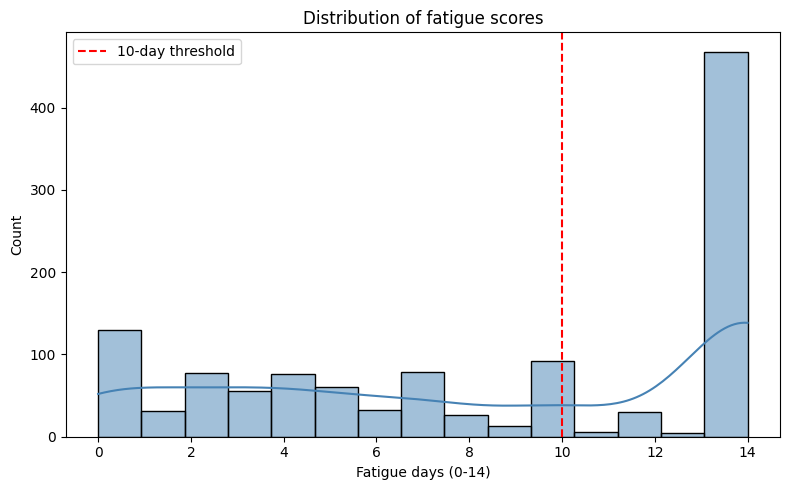

Saved histogram to /Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/output/all_ibd/regression/plots/fatigue_score_distribution.png


In [5]:
plt.figure(figsize=(8, 5))
sns.histplot(df["fatigue_score"], bins=15, kde=True, color="steelblue")
plt.axvline(10, color="red", linestyle="--", label="10-day threshold")
plt.xlabel("Fatigue days (0-14)")
plt.ylabel("Count")
plt.title("Distribution of fatigue scores")
plt.legend()
plt.tight_layout()

hist_path = REGRESSION_DIR / "plots" / "fatigue_score_distribution.png"
plt.savefig(hist_path, dpi=300)
plt.show()
print(f"Saved histogram to {hist_path}")


## Train/validation/test split and scaling

In [6]:
def split_data_for_regression(dataframe: pd.DataFrame, features: list):
    # Group-aware split mirroring the classification ratios (65/15/20).
    primary_split = GroupShuffleSplit(
        test_size=0.36, n_splits=1, random_state=RANDOM_SEED
    )

    for train_idx, holdout_idx in primary_split.split(
        dataframe, groups=dataframe["study_id"]
    ):
        train_df = dataframe.iloc[train_idx]
        holdout_df = dataframe.iloc[holdout_idx]

    val_split = GroupShuffleSplit(test_size=0.56, n_splits=1, random_state=RANDOM_SEED)
    for val_idx, test_idx in val_split.split(holdout_df, groups=holdout_df["study_id"]):
        val_df = holdout_df.iloc[val_idx]
        test_df = holdout_df.iloc[test_idx]

    X_train = train_df[features].copy()
    y_train = train_df["fatigue_score"].copy()

    X_val = val_df[features].copy()
    y_val = val_df["fatigue_score"].copy()

    X_test = test_df[features].copy()
    y_test = test_df["fatigue_score"].copy()

    groups = train_df["study_id"].copy()
    return X_train, X_val, X_test, y_train, y_val, y_test, groups


X_train, X_val, X_test, y_train, y_val, y_test, groups = split_data_for_regression(
    df, feature_columns
)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (745, 65)
Val shape: (193, 65)
Test shape: (243, 65)


In [7]:
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])

for split in [X_train, X_val, X_test]:
    split.loc[:, numerical_features] = scaler.transform(split[numerical_features])

print("Scaling complete for numerical features")


Scaling complete for numerical features


## Helper functions and result containers

In [8]:
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}


def add_results(model_name, split, y_true, y_pred, store, pred_store, key):
    metrics = regression_metrics(y_true, y_pred)
    metrics.update({"Model": model_name, "Split": split})
    store.append(metrics)
    pred_store.setdefault(model_name, {})[key] = y_pred


metrics_rows = []
prediction_store = {}


## Baseline (mean) regressor

In [9]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

val_pred = dummy.predict(X_val)
test_pred = dummy.predict(X_test)

add_results("Dummy Mean", "val", y_val, val_pred, metrics_rows, prediction_store, "val")
add_results("Dummy Mean", "test", y_test, test_pred, metrics_rows, prediction_store, "test")

print("Baseline MAE (val/test):", regression_metrics(y_val, val_pred)["MAE"], regression_metrics(y_test, test_pred)["MAE"])


Baseline MAE (val/test): 4.8742984316861975 4.859877924158313


/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/chershiongchuah/Developer/machine

## Deep neural network regressor

In [10]:
dnn_model = keras.Sequential(
    [
        layers.Dense(256, activation="relu", input_shape=(X_train.shape[1],)),
        layers.Dropout(0.2),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(1, activation="linear"),
    ]
)

dnn_model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0005),
    loss="mse",
    metrics=[
        keras.metrics.RootMeanSquaredError(name="rmse"),
        keras.metrics.MeanAbsoluteError(name="mae"),
    ],
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=15, restore_best_weights=True
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6
)

history = dnn_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=0,
)

history_df = pd.DataFrame(history.history)
print(history_df.tail())


/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


         loss       mae      rmse   val_loss   val_mae  val_rmse  \
31  13.581138  2.936637  3.685260  25.085907  4.073472  5.008584   
32  14.024469  2.975188  3.744926  24.618969  4.047671  4.961751   
33  13.579741  2.890449  3.685070  25.332945  4.084003  5.033185   
34  13.091674  2.910445  3.618242  25.131216  4.070618  5.013104   
35  13.730612  2.951797  3.705484  25.250509  4.075755  5.024989   

    learning_rate  
31       0.000125  
32       0.000125  
33       0.000125  
34       0.000125  
35       0.000125  


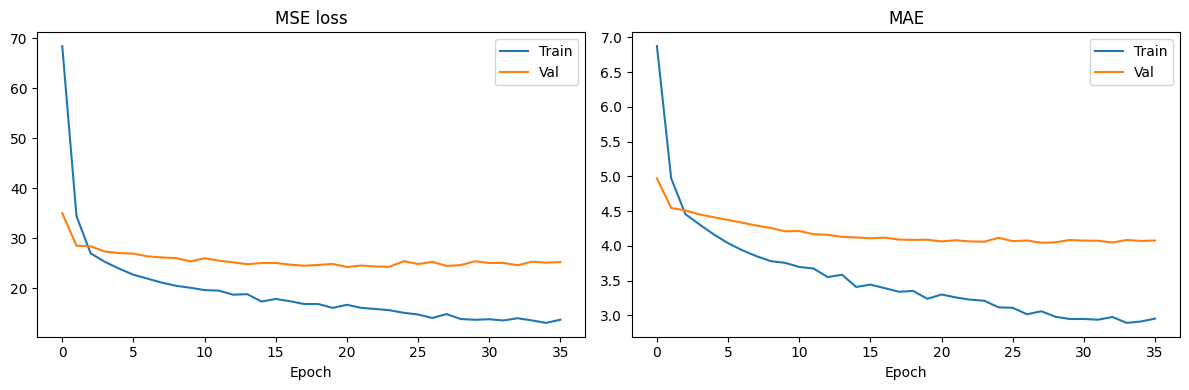

Saved DNN training curves to /Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/output/all_ibd/regression/plots/dnn_training_curves.png
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history.history["loss"], label="Train")
axes[0].plot(history.history["val_loss"], label="Val")
axes[0].set_title("MSE loss")
axes[0].set_xlabel("Epoch")
axes[0].legend()

axes[1].plot(history.history["mae"], label="Train")
axes[1].plot(history.history["val_mae"], label="Val")
axes[1].set_title("MAE")
axes[1].set_xlabel("Epoch")
axes[1].legend()

plt.tight_layout()
loss_plot_path = REGRESSION_DIR / "plots" / "dnn_training_curves.png"
plt.savefig(loss_plot_path, dpi=300)
plt.show()
print(f"Saved DNN training curves to {loss_plot_path}")

val_pred = dnn_model.predict(X_val).ravel()
test_pred = dnn_model.predict(X_test).ravel()
add_results("DNN Regressor", "val", y_val, val_pred, metrics_rows, prediction_store, "val")
add_results("DNN Regressor", "test", y_test, test_pred, metrics_rows, prediction_store, "test")


## Scikit-learn regressors with small grid search

In [12]:
regression_models = {
    "Random Forest": (
        RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1),
        {"n_estimators": [400, 800], "max_depth": [None, 12], "min_samples_split": [2, 5]},
    ),
    "XGBoost": (
        XGBRegressor(
            random_state=RANDOM_SEED,
            objective="reg:squarederror",
            eval_metric="rmse",
            n_jobs=-1,
        ),
        {"n_estimators": [300, 600], "max_depth": [3, 6], "learning_rate": [0.01, 0.1]},
    ),
}

best_params = {}
cv = GroupKFold(n_splits=5)

for model_name, (model, param_grid) in regression_models.items():
    print(f"Tuning {model_name}...")
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
    )
    grid.fit(X_train, y_train, groups=groups)
    best_params[model_name] = grid.best_params_
    best_model = grid.best_estimator_

    val_pred = best_model.predict(X_val)
    test_pred = best_model.predict(X_test)

    add_results(model_name, "val", y_val, val_pred, metrics_rows, prediction_store, "val")
    add_results(model_name, "test", y_test, test_pred, metrics_rows, prediction_store, "test")

    print(f"Best params for {model_name}: {grid.best_params_}")

params_path = REGRESSION_DIR / "metrics" / "best_params.json"
with open(params_path, "w") as f:
    json.dump(best_params, f, indent=2)
print(f"Saved tuned parameters to {params_path}")


Tuning Random Forest...


/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Best params for Random Forest: {'max_depth': 12, 'min_samples_split': 5, 'n_estimators': 400}
Tuning XGBoost...
Best params for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 600}
Saved tuned parameters to /Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/output/all_ibd/regression/metrics/best_params.json


/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Results summary and best-model scatter plot

In [13]:
metrics_df = pd.DataFrame(metrics_rows)
metrics_df = metrics_df.round(3)

results_path = REGRESSION_DIR / "metrics" / "regression_metrics.csv"
metrics_df.to_csv(results_path, index=False)
print(f"Saved metrics to {results_path}")

metrics_df.sort_values(["Split", "RMSE"], inplace=True)
metrics_df


Saved metrics to /Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/output/all_ibd/regression/metrics/regression_metrics.csv


,MAE,RMSE,R2,Model,Split
5,3.951,4.789,0.172,Random Forest,test
7,4.079,4.919,0.126,XGBoost,test
1,4.860,5.283,-0.008,Dummy Mean,test
3,4.544,7.651,-1.114,DNN Regressor,test
4,4.055,4.704,0.215,Random Forest,val
6,4.077,4.722,0.208,XGBoost,val
2,4.063,4.925,0.139,DNN Regressor,val
0,4.874,5.390,-0.031,Dummy Mean,val


Lowest test RMSE model: Random Forest


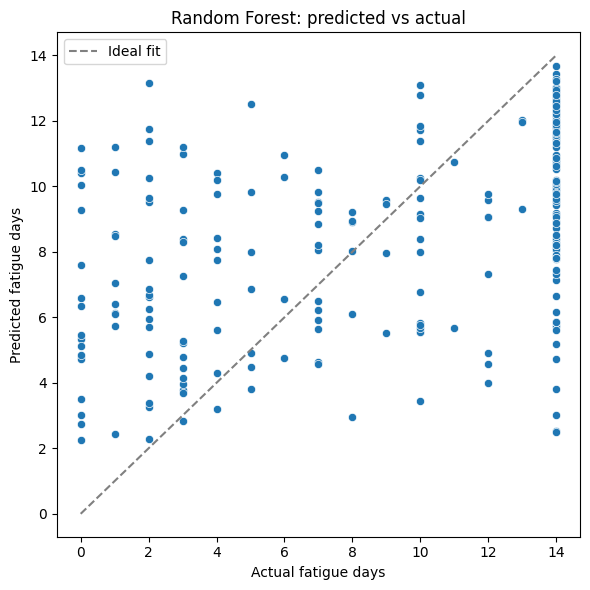

Saved scatter plot to /Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/output/all_ibd/regression/plots/best_model_pred_vs_actual.png


In [14]:
test_results = metrics_df[metrics_df["Split"] == "test"].copy()
best_row = test_results.sort_values("RMSE").iloc[0]
best_model_name = best_row["Model"]
print(f"Lowest test RMSE model: {best_model_name}")

best_pred = prediction_store[best_model_name]["test"]

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=best_pred, s=35)
plt.plot([0, 14], [0, 14], linestyle="--", color="grey", label="Ideal fit")
plt.xlabel("Actual fatigue days")
plt.ylabel("Predicted fatigue days")
plt.title(f"{best_model_name}: predicted vs actual")
plt.legend()
plt.tight_layout()
scatter_path = REGRESSION_DIR / "plots" / "best_model_pred_vs_actual.png"
plt.savefig(scatter_path, dpi=300)
plt.show()
print(f"Saved scatter plot to {scatter_path}")
